In [1]:
import pygame
import sys
import time
import random

import pygame.locals as pgl

import numpy as np

import networkx as nx
import epydemic

from custom_disease_model import Kennels, DistemperModel
# from aggregate_visualization import AggregatePlot

from copy import copy, deepcopy

from threading import Thread

import logging

import multiprocessing
from multiprocessing import Pool

import tqdm

import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from matplotlib import cm

from interventions import SortIntervention, TimedRemovalIntervention, RoomLockIntervention

class Simulation(object):
    
    def __init__(self, params, spatial_visualization=True, aggregate_visualization=True, return_on_equillibrium=False):
        self.return_on_equillibrium = return_on_equillibrium
        self.spatial_visualization = spatial_visualization
        self.aggregate_visualization = aggregate_visualization

        if not self.spatial_visualization and not self.aggregate_visualization and not self.return_on_equillibrium:
            logging.warning('Warning: No visualizations were set, it is highly recommended you set return_on_equillibrium to True otherwise you will have to manually manage the simulation state.')

        self.params = params
        if 'infection_kernel_function' in self.params and type(self.params['infection_kernel_function']) == str:
            self.params['infection_kernel_function'] = eval(self.params['infection_kernel_function'])
        else:
            self.params['infection_kernel_function'] = lambda node, k: 0.0
        if 'intervention' in self.params and type(self.params['intervention']) == str:
            self.params['intervention'] = eval(self.params['intervention'])
        else:
            self.params['intervention'] = None
        self.kennels = Kennels()
        self.disease = DistemperModel(self.kennels.get_graph(), self.params)

        self.update_hooks = []

#         if spatial_visualization:
#             self.FPS = 0
#             self.SCREEN_WIDTH, self.SCREEN_HEIGHT = 640, 480
#             pygame.init()
#             self.fpsClock = pygame.time.Clock()
#             self.screen = pygame.display.set_mode((self.SCREEN_WIDTH, self.SCREEN_HEIGHT), 0, 32)
#             self.surface = pygame.Surface(self.screen.get_size())
#             self.surface = self.surface.convert()
#             self.surface.fill((255,255,255))
#             self.clock = pygame.time.Clock()

#             pygame.key.set_repeat(1, 40)
        
#             self.screen.blit(self.surface, (0,0))

#             self.font = pygame.font.Font(None, 36)
        
#         if aggregate_visualization:
#             self.plt = AggregatePlot(self.disease, self.kennels)
#             self.update_hooks.append(self.plt.update)

    def check_events(self):
        for event in pygame.event.get():
            if event.type == pgl.QUIT:
                pygame.quit()
                sys.exit()
            elif event.type == pgl.KEYDOWN:
                if event.key == pgl.K_ESCAPE:
                    pygame.quit()
                    sys.exit()

    def redraw(self):
        self.screen.blit(self.surface, (0,0))
        pygame.display.flip()
        pygame.display.update()
        self.fpsClock.tick(self.FPS)

    def draw_ui(self):
        text = self.font.render('{0} days, {1} hours'.format(int(np.floor(self.disease.t/24.0)), self.disease.t%24), 1, (10, 10, 10))
        textpos = text.get_rect()
        textpos.centerx = 200
        self.surface.blit(text, textpos)

    def get_disease_state(self):
        return {sc: len(self.disease.get_state_node(sc)['members']) for sc in self.disease.id_map.keys()}
        
    def update(self):
        if self.spatial_visualization:
            self.check_events()
            self.surface.fill((255,255,255))

        if not self.disease.in_equilibrium():
            if 'intervention' in self.params and self.params['intervention'] != None:
                self.params['intervention'].update(simulation=self)
            self.disease.update(self.kennels)
        elif self.return_on_equillibrium:
            self.running = False
            return

        for hook in self.update_hooks:
            print(hook)
            hook()
        
        if self.spatial_visualization:
            self.kennels.draw(self.surface, self.disease)
            self.draw_ui()
            self.redraw()
    
    def stop(self):
        self.running = False

    def run(self, asynchronous=False):
        self.running = True
        if asynchronous:
            self.async_thread = Thread(target=self.run, args=(False,))
            self.async_thread.start()
        else:
            while self.running:
                self.update()
            return self.get_disease_state()

class BatchSimulation(object):
    def __init__(self, params, runs, pool_size=-1):
        self.params = params
        self.runs = runs
        if pool_size == None:
            self.pool_size = 1
        elif pool_size <= 0:
            self.pool_size = multiprocessing.cpu_count()
        
    def run(self):
        results = []
        with Pool(self.pool_size) as p:
            for i in tqdm.tqdm(p.imap_unordered(BatchSimulation.run_simulation, [deepcopy(self.params) for _ in range(0, self.runs)]), total=self.runs):
                results.append(i)
            p.close()
            p.join()
        return results
            
    @staticmethod
    def run_simulation(params):
        return Simulation(params, spatial_visualization=False, aggregate_visualization=False, return_on_equillibrium=True).run()

def main(batch=False):
    params = {
            'pIntake': 0.25,
            'pInfect': 0.04,
            'pSurvive': 0.0025,
            'pDie': 0.0058333333333333,
            'pDieAlternate': 0.0,
            'refractoryPeriod': 3.0*24.0,
            'infection_kernel': [0.5, 0.25],
            'infection_kernel_function': 'lambda node, k: k*(1-node[\'occupant\'][\'immunity\'])',
            'immunity_growth_factors': [1.03, 0.001], # _[0]*immunity+_[1]
            'intervention': 'SortIntervention()'
        }
    if not batch:
        sim = Simulation(params, spatial_visualization=True, return_on_equillibrium=False, aggregate_visualization=False)
#         print(sim.run())
    else:
        runs = 32
        bar_width = 0.35
        proportion = True
        colors = [cm.jet(0), cm.jet(0.5)]
        alphas = [0.5, 0.25]
        labels = ['Sort Intervention', 'No Intervention']
        
        params1 = copy(params)
        params1['intervention'] = None
        
        results = BatchSimulation(params, runs).run()

        total = sum(list(results[0].values()))
        df = pd.DataFrame.from_records(results)
        if proportion:
            df /= total
        
        plt.rcdefaults()

        objects = df.columns
        y_pos = np.arange(len(objects))
        
        plt.bar(y_pos-bar_width/2, df.mean(), bar_width, align='center', alpha=alphas[0], yerr=df.std()/np.sqrt(len(df)), color=colors[0], label=labels[0])
        
        results = BatchSimulation(params1, runs).run()
        df = pd.DataFrame.from_records(results)
        if proportion:
            df /= total
        plt.bar(y_pos+bar_width/2, df.mean(), bar_width, align='center', alpha=alphas[1], yerr=df.std()/np.sqrt(len(df)), color=colors[1], label=labels[1])

        plt.xticks(y_pos, objects)
        plt.ylabel('Mean Animal Count')
        plt.ylim(0, 1)
        plt.title('Average Simulation Performance')
        plt.legend()

        plt.show()
    

pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# Parameter fitting based on real data
from lmfit import Minimizer, Parameters, report_fit

params = {
        'pIntake': 0.25,
        'pInfect': 0.04,
        'pSurvive': 0.0025,
        'pDie': 0.0058333333333333,
        'pDieAlternate': 0.0,
        'refractoryPeriod': 3.0*24.0,
        'infection_kernel': [0.5, 0.25],
        'infection_kernel_function': 'lambda node, k: k*(1-node[\'occupant\'][\'immunity\'])',
        'immunity_growth_factors': [1.03, 0.001], # _[0]*immunity+_[1]
        'intervention': 'SortIntervention()'
    }

# Add parameters to try and optimize
optimize_params = Parameters()
optimize_params.add('pIntake',value=params['pIntake'], min=0)
optimize_params.add('pInfect',value=params['pInfect'], min=0)
optimize_params.add('pSurvive',value=params['pSurvive'], min=0)
optimize_params.add('pDie',value=params['pDie'], min=0)
optimize_params.add('pDieAlternate',value=params['pDieAlternate'], min=0)
optimize_params.add('refractoryPeriod',value=params['refractoryPeriod'], min=0)

time = np.arange(0,10)
data = np.ones(len(time))
# do fit, here with leastsq model
minner = Minimizer(error_function, optimize_params, fcn_args=(time, data))
result = minner.minimize()

NameError: name 'error_function' is not defined

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 10
    # variables        = 6
    chi-square         = 90250.0000
    reduced chi-square = 22562.5000
    Akaike info crit   = 103.077538
    Bayesian info crit = 104.893048
[[Variables]]
    pIntake:           0.25000000 (init = 0.25)
    pInfect:           0.04000000 (init = 0.04)
    pSurvive:          0.00250000 (init = 0.0025)
    pDie:              0.00583330 (init = 0.0058333)
    pDieAlternate:     0.00000000 (init = 0)
    refractoryPeriod:  72.0000011 (init = 72)


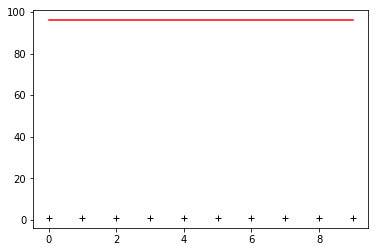

In [106]:
# calculate final result
final = data + result.residual

# write error report
report_fit(result)

# try to plot results
try:
    import matplotlib.pyplot as plt
    plt.plot(time, data, 'k+')
    plt.plot(time, final, 'r')
    plt.show()
except ImportError:
    pass

In [ ]:
def error_function(optimize_params, time, actual_data):
    """ Model to calculate the difference between simulated and actual data
        Arguments:
            optimize_params {dictionary} -- list of parameters to use in optimization
            time {array} -- time length of simulation
            actual_data {array} -- array of data from real simulation
        Outputs:
            error {float} -- inner product between two curves
    """
    
    params = {
        'pIntake': optimize_params['pIntake'],
        'pInfect': optimize_params['pInfect'],
        'pSurvive': optimize_params['pSurvive'],
        'pDie': optimize_params['pDie'],
        'pDieAlternate': optimize_params['pDieAlternate'],
        'refractoryPeriod': optimize_params['refractoryPeriod'],
        'infection_kernel': [0.5, 0.25],
        'infection_kernel_function': 'lambda node, k: k*(1-node[\'occupant\'][\'immunity\'])',
        'immunity_growth_factors': [1.03, 0.001], # _[0]*immunity+_[1]
        'intervention': 'SortIntervention()'
    }
    results = average_simulation(params,runs,time)
    empty_results = results.E.mean()
    infected_results = results.I.mean()
    simulated_data = infected_results
#     actual_data = np.ones(len(simulated_data))
    diff = simulated_data - actual_data
    return diff

In [3]:
def average_simulation(params,runs=10,simulation_time=np.arange(1,10)):
    """ Script to run simulation with a specific type of intervention multiple times and average the data 
        
        Arguments:
            params {dict} -- current parameter settings
            runs {int} -- number of times to run simulation and then averaged
            simulation_time {array} -- how long to run simulation for
        Outputs:
            results {pandas.core.groupby.DataFrameGroupBy} -- results grouped by day with each column as a state (i.e. D,E,etc)
    """
    
    for run in range(runs):
        if run == 0: 
            sim = Simulation(params, spatial_visualization=False, return_on_equillibrium=True, aggregate_visualization=False)
        else: 
            del(sim)
            sim = Simulation(params, spatial_visualization=False, return_on_equillibrium=True, aggregate_visualization=False)
        df_tmp = pd.DataFrame(sim.get_disease_state(),index=[0])
        for simul_time in simulation_time:
            sim.update()
            tmp = pd.DataFrame(sim.get_disease_state(),index=[simul_time])
            df_tmp = df_tmp.append(tmp)
            try:
                df_concat = df_concat.append((tmp))
            except:
                df_concat = df_tmp
    results = df_concat.groupby(df_concat.index)
    return results

In [4]:
# Run simulation multiple times and average results for each type of intervention
results = {}
simulation_time = np.arange(1,50)
runs = 100
Interventions = [None] # ['SortIntervention()','RoomLockIntervention()']
Interventions = ['SortIntervention()']#,'RoomLockIntervention()']
for intervention in Interventions:
    params['intervention'] = intervention
    results[intervention] = average_simulation(params,runs,simulation_time)

/mnt/c/Users/Awesome/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


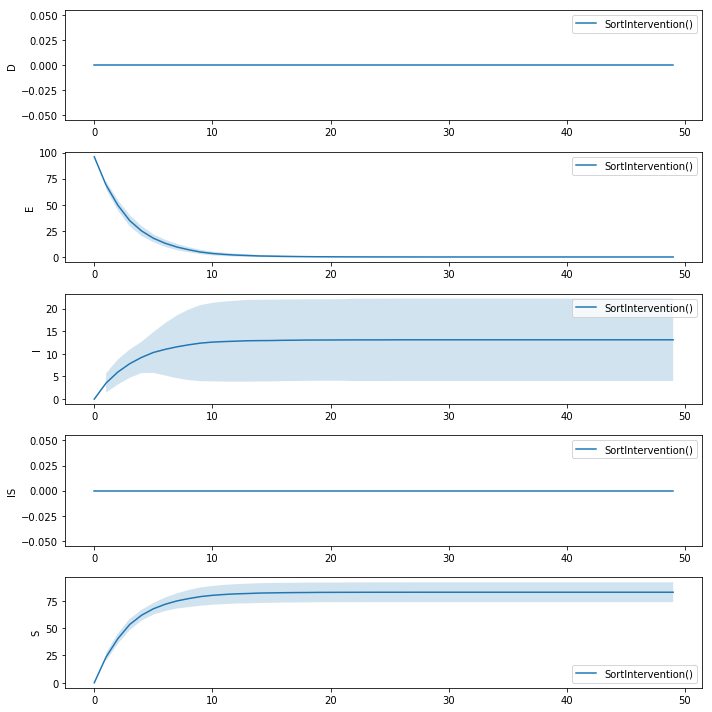

In [5]:
Fig, ax = plt.subplots(5,figsize = (10,10))
for intervention in Interventions:
    df_means = results[intervention].mean()
    df_std = results[intervention].std()
    x = np.array(df_means.index)
    for idx,col in enumerate(df_means.columns):
        y = df_means[col]
        y_low = df_means[col] - df_std[col]
        y_high = df_means[col] + df_std[col]
        ax[idx].plot(x,y,label=intervention)
        ax[idx].fill_between(x,y_low,y_high,alpha=0.2)
        ax[idx].set_ylabel(col)
        
for aa in ax:
    aa.legend()
Fig.set_tight_layout('tight')

In [6]:
sim = Simulation(params, spatial_visualization=False, return_on_equillibrium=True, aggregate_visualization=False)

In [7]:
sim.update()

In [18]:
results = average_simulation(params,runs = 3, simulation_time=np.arange(1,100))

In [19]:
results.head()

,D,E,I,IS,S
0,0,96,0,0,0
1,0,75,2,0,19
2,0,56,7,0,33
3,0,43,8,0,45
4,0,32,11,0,53
5,0,24,12,0,60
6,0,21,12,0,63
7,0,16,12,0,68
8,0,14,13,0,69
9,0,12,13,0,71
